# Problem Set 7
## Daniel Tracht

## Question 1
In this question, we will be using the data from the strongdrink.txt file.

In [1]:
import pandas as pd

wine = pd.read_csv('data/strongdrink.txt')

wine.head()

,cultivar,alco,malic,ash,alk,magn,tot_phen,flav,nonfl_phen,proanth,color_int,hue,OD280rat,proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


### Part a
We wish to estimate a multinomial logistic regression model for the cultivar, where the baseline class is 3.  We will estimate on a training set containing 75 percent of our observations.

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, mean_squared_error
from sklearn.linear_model import LogisticRegression
import numpy as np

# Define the needed variables for this analysis
# Using .values so I don't have to define new matrix for subsquent problems
X = wine[["alco", "malic", "tot_phen", "color_int"]].values
y = wine["cultivar"].values

# Divide the data into 75% training and 25% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25,
                                                    random_state = 20)

# Run the regression
LogReg = LogisticRegression(random_state=20, solver="lbfgs",
                            multi_class='multinomial', max_iter=1000)
train = LogReg.fit(X_train, y_train)

# coefs and intercepts are ordered j=1, j=2, j=3
print("For j=1:")
print("Intercept:", train.intercept_[0])
print("Betas 1 through 4", train.coef_[0])

print("For j=2:")
print("Intercept:", train.intercept_[1])
print("Betas 1 through 4", train.coef_[1])

# generating classification_report
y_pred = LogReg.predict(X_test)
print("Our classification report:")
print(classification_report(y_test, y_pred))

# generating MSE
print('Test set MSE = ', mean_squared_error(y_test, y_pred))

For j=1:
Intercept: -24.02761652694668
Betas 1 through 4 [ 1.70173443 -0.26578756  1.22410094  0.02250699]
For j=2:
Intercept: 22.78073250150875
Betas 1 through 4 [-1.46629729 -0.33295144  0.66355615 -0.92268168]
Our classification report:
              precision    recall  f1-score   support

           1       0.87      1.00      0.93        13
           2       1.00      0.90      0.95        21
           3       1.00      1.00      1.00        10

   micro avg       0.95      0.95      0.95        44
   macro avg       0.96      0.97      0.96        44
weighted avg       0.96      0.95      0.96        44

Test set MSE =  0.045454545454545456


We find that the error rate for cultivar 1 is the only one that is not zero for the quarter of the data we left as a test.  Using the f1-score as our measure, our model was best at classifying wines of cultivar 3.  This is also the category with the fewest observations (and so fewest chances to make a mistake).

### Part b
In this question, we want to use LOOCV with the model from part a.  We want to report our error rates for each category.  We want to report the LOOCV MSE for each test, as well as the average across all tests:

In [3]:
from sklearn.model_selection import LeaveOneOut

# Setting up with the number of observations, a vector of 0s to hold MSEs
#  and a matrix to hold precision
N_loo = X.shape[0]
loo = LeaveOneOut()
loo.get_n_splits(X)
MSE_loo = np.zeros(N_loo)

# Adding a column of zeros to our data
wine["zeros"] = 0
# making matrix with our y and the column of zeros
precision_loo = wine[["cultivar", "zeros"]].values

In [4]:
# Running the loop
for train_index, test_index in loo.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    LogReg = LogisticRegression(random_state=20, solver="lbfgs",
                                multi_class='multinomial', max_iter=1000)
    LogReg.fit(X_train, y_train)
    y_pred = LogReg.predict(X_test)
    # have to use indicator since multinomial
    if y_pred == y_test:
        MSE_loo[test_index] = 0
        precision_loo[test_index,1] = 1
    else:
        MSE_loo[test_index] = 1

In [5]:
# Defining the subsets of the larger precision matrix for the three cultivars
prec_1 = precision_loo[np.where(precision_loo[:,0] == 1)]
prec_2 = precision_loo[np.where(precision_loo[:,0] == 2)]
prec_3 = precision_loo[np.where(precision_loo[:,0] == 3)]

print("Error rate for cultivar 1:", 1 - prec_1[:,1].mean())
print("Error rate for cultivar 2:", 1 - prec_2[:,1].mean())
print("Error rate for cultivar 3:", 1 - prec_3[:,1].mean())

print("Mean MSE across all LOOCV tests", MSE_loo.mean())

Error rate for cultivar 1: 0.06779661016949157
Error rate for cultivar 2: 0.09859154929577463
Error rate for cultivar 3: 0.06521739130434778
Mean MSE across all LOOCV tests 0.07954545454545454


While the error rate for cultivar 1 decreased from 0.13 to 0.07, the error rates from cultivars 2 and 3 increased from 0 to 0.10 and 0.07 respectively.

### Part c
In this question, we want to use $k$-fold cross validation in which $k=4$.

In [6]:
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix

# Using the code as specified
kf = KFold(n_splits=4, shuffle=True, random_state=10)
kf.get_n_splits(X)

MSE_kf = np.zeros(4)

# initializing for precision metrics
c1_pred = 0
c2_pred = 0
c3_pred = 0

c1_wrong = 0
c2_wrong = 0
c3_wrong = 0

In [7]:
k_ind = int(0)
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    LogReg = LogisticRegression(random_state=10, solver="lbfgs",
                                multi_class='multinomial', max_iter=1000)
    LogReg.fit(X_train, y_train)
    y_pred = LogReg.predict(X_test)
    MSE_kf[k_ind] = ((y_test != y_pred) ** 2).mean()
    # updating precision counts
    raveled = confusion_matrix(y_test, y_pred).ravel()
    c1_pred = c1_pred+raveled[0]+raveled[3]+raveled[6]
    c1_wrong = c1_wrong+raveled[3]+raveled[6]
    c2_pred = c2_pred+raveled[1]+raveled[4]+raveled[7]
    c2_wrong = c2_wrong+raveled[1]+raveled[7]
    c3_pred = c3_pred+raveled[2]+raveled[5]+raveled[8]
    c3_wrong = c3_wrong+raveled[2]+raveled[5]
    k_ind += 1
print("Cultivar 1 error rate:", c1_wrong/c1_pred)
print("Cultivar 2 error rate:", c2_wrong/c2_pred)
print("Cultivar 3 error rate:", c3_wrong/c3_pred)
print('Mean MSE across all k-Fold tests=', MSE_kf.mean())

Cultivar 1 error rate: 0.12698412698412698
Cultivar 2 error rate: 0.08823529411764706
Cultivar 3 error rate: 0.044444444444444446
Mean MSE across all k-Fold tests= 0.09090909090909091


Compared to the LOOCV, our error rate for Cultivar 1 is higher, though lower for Cultivars 2 and 3.  Our MSE is slightly higher.  Compared to our simple split, our error rate for Cultivar 1 is about the same, though much higher for cultivars 2 and 3.  Our MSE is much higher as well.

## Question 2
In this question, we will be using the data from CoolIndex.txt

In [8]:
cool = pd.read_csv('data/CoolIndex.txt', header=None, names=["age", "cool"])

cool.describe()

,age,cool
count,956.000000,956.000000
mean,44.385983,32.790118
std,20.250954,9.246635
min,11.000000,7.942515
25%,27.000000,29.219091
50%,44.000000,33.721898
75%,60.000000,37.453531
max,95.000000,63.649347


### Part a
We wish to make a scatter plot of our data

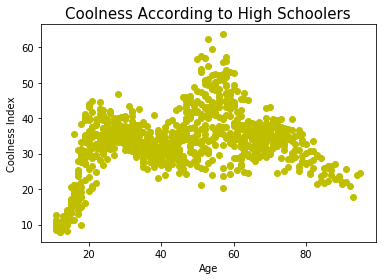

In [19]:
import matplotlib.pyplot as plt

# Yellow is ugly, but lets the later lines be more visible
plt.scatter(cool.age, cool.cool, c="y")
plt.title("Coolness According to High Schoolers", fontsize=15)
plt.xlabel("Age")
plt.ylabel("Coolness Index")
plt.show()

### Part b
We wish to use OLS to find a stepwise function to fit these data using the given bins, and add them to our plot

In [22]:
import statsmodels.api as sm

# Using the bins as defined in the problem set
cool["bin1"] = np.where( (cool.age >= 11) & (cool.age < 22), 1, 0)
cool["bin2"] = np.where( (cool.age >= 22) & (cool.age < 40), 1, 0)
cool["bin3"] = np.where( (cool.age >= 40) & (cool.age < 59), 1, 0)
cool["bin4"] = np.where( (cool.age >= 59) & (cool.age < 77), 1, 0)
cool["bin5"] = np.where( (cool.age >= 77) & (cool.age <= 95), 1, 0)

X=cool[["bin1", "bin2", "bin3", "bin4", "bin5"]]
step=sm.OLS(cool.cool, X).fit()
print(step.summary())

                            OLS Regression Results                            
Dep. Variable:                   cool   R-squared:                       0.429
Model:                            OLS   Adj. R-squared:                  0.427
Method:                 Least Squares   F-statistic:                     178.7
Date:                Wed, 27 Feb 2019   Prob (F-statistic):          3.73e-114
Time:                        07:14:03   Log-Likelihood:                -3214.5
No. Observations:                 956   AIC:                             6439.
Df Residuals:                     951   BIC:                             6463.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
bin1          20.1025      0.562     35.746      0.0

Our estimated vector of $\beta$ values are the coefficients from the above regression.  Our predicted coolness of a 73 year old would be the coefficient for bin4.

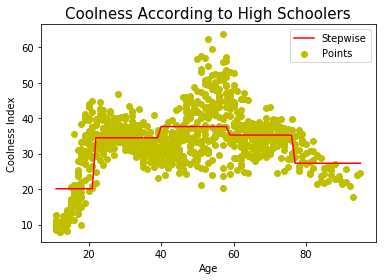

In [21]:
# Adding to our plots
plt.scatter(cool.age, cool.cool, c="y", label = "Points")
plt.plot(cool.age, step.predict(), c="r" , label = "Stepwise")
plt.legend()
plt.title("Coolness According to High Schoolers", fontsize=15)
plt.xlabel("Age")
plt.ylabel("Coolness Index")
plt.show()

### Part c
In this question, we want to use a continuous linear spline over the same bins as in the previous question with the given knots, and then add it to our plot.

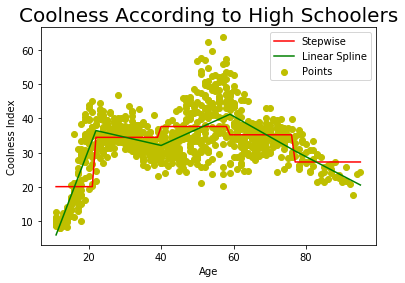

Predicted coolness for a 73 year old: 32.86784862349653


In [16]:
from scipy.interpolate import LSQUnivariateSpline

cool2=cool.groupby("age").mean()
cool2["age"]=cool2.index

# As defined in the problem set
knots = [22,40,59,77]

lin_spline = LSQUnivariateSpline(cool2.age.values, cool2.cool.values,
                                 t = knots, k = 1)

# Adding to our plots
plt.scatter(cool.age, cool.cool, c="y", label = "Points")
plt.plot(cool.age, step.predict(), c="r" , label = "Stepwise")
plt.plot(cool2.age,lin_spline(cool2.age), c="g", label = "Linear Spline")
plt.legend()
plt.title("Coolness According to High Schoolers", fontsize=15)
plt.xlabel("Age")
plt.ylabel("Coolness Index")
plt.show()

print("Predicted coolness for a 73 year old:", lin_spline(73))

### Part d
In this question, we want to use a cubic spline over the same bins as before with the same knots, and add it to our plot.

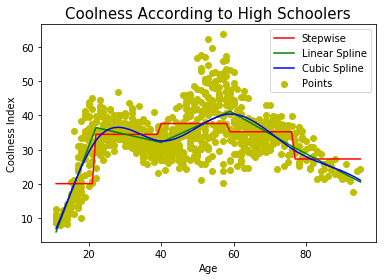

Predicted coolness for a 73 year old: 32.642301066279764


In [18]:
cub_spline = LSQUnivariateSpline(cool2.age.values, cool2.cool.values,
                                 t = knots, k = 3)

# Adding to our plots
plt.scatter(cool.age, cool.cool, c="y", label = "Points")
plt.plot(cool.age, step.predict(), c="r" , label = "Stepwise")
plt.plot(cool2.age,lin_spline(cool2.age), c="g", label = "Linear Spline")
plt.plot(cool2.age,cub_spline(cool2.age), c="b", label = "Cubic Spline")
plt.legend()
plt.title("Coolness According to High Schoolers", fontsize=15)
plt.xlabel("Age")
plt.ylabel("Coolness Index")
plt.show()

print("Predicted coolness for a 73 year old:", cub_spline(73))